# LANL Earthquake Prediction
A *Short-Time Fourier Transform* analysis introduction

-----------------------

## 1. Introduction
In this notebook I seek to apply a simplified EDA on the available training data. Going further, and since earthquake data are strongly related to cyclic events, I intend to explore this data on the Fourier domain. 

In [1]:
### Importing libraries
import numpy as np
import pandas as pd

import matplotlib.colors as colors
import matplotlib.pyplot as plt

%matplotlib inline

import scipy.signal as signal
import os
import gc

## 2. Analyzing the data

In [2]:
## Listing the files in the directory
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In order to make it easy to deal with, we will start reading just a small portion of the data. To do so we will use the *skiprows* and *nrows* parameters:

In [4]:
train = pd.read_csv('../input/train.csv', skiprows=range(1,4000000), nrows=2000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

Notice I had to skip the first 4M samples due to memory overuse here in Kaggle's cloud environment. Running on my local computer, it's better setting the *skiprows* parameter with the value 0, so the time-frequency analysis will be shown with the right time scale. In the next versions of this kernel a short function can be defined to treat this correctly. 

In [5]:
## Checking the number of samples in the file
print("Dataset size:", train.shape)

Dataset size: (2000000, 2)


In [6]:
## Showing the first data samples with high precision
pd.set_option("display.precision", 10)
train.head()

,acoustic_data,time_to_failure
0,-4,0.4306974499
1,-3,0.4306974488
2,-6,0.4306974477
3,-3,0.4306974466
4,-3,0.4306974455


An important aspect of the data, when dealing with time-frequency analysis, is the sampling rate. Accordingly to the [additional information](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526), *the input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.*  

Given the sampling frequency ($4{MHz}$) and the number of samples ($N=1e7$), we can estimate the time length of the signal:

In [7]:
(1/4e6)*1e7

2.5

Notice that since we are skipping the first $4e6$ samples, we have a resulting sinal length of 0.5s that is equivalent to the interval from 1.0 to 1.5 seconds of the original signal.


### 2.1 Short-Time Fourier Transform

The following function will be used to calculate the *Short-Time Fourier Transform* for a given signal.

In [8]:
def calcSTFT_norm(inputSignal, samplingFreq, window='hann', nperseg=256, figsize=(9,5), cmap='magma', ylim_max=None):
    '''Calculates the STFT for a time series:
        inputSignal: numpy array for the signal (it also works for Pandas.Series);
        samplingFreq: the sampling frequency;
        window : str or tuple or array_like, optional
            Desired window to use. If `window` is a string or tuple, it is
            passed to `get_window` to generate the window values, which are
            DFT-even by default. See `get_window` for a list of windows and
            required parameters. If `window` is array_like it will be used
            directly as the window and its length must be nperseg. Defaults
            to a Hann window.
        nperseg : int, optional
            Length of each segment. Defaults to 256.
        figsize: the plot size, set as (6,3) by default;
        cmap: the color map, set as the divergence Red-Yellow-Green by default;
        ylim_max: the max frequency to be shown. By default it's the half sampling frequency.'''
    ##Calculating STFT
    f, t, Zxx = signal.stft(inputSignal, samplingFreq, window=window, nperseg=nperseg)
    ##Plotting STFT
    fig = plt.figure(figsize=figsize)
    ### Different methods can be chosen for normalization: PowerNorm; LogNorm; SymLogNorm.
    ### Reference: https://matplotlib.org/tutorials/colors/colormapnorms.html
    spec = plt.pcolormesh(t, f, np.abs(Zxx), 
                          norm=colors.PowerNorm(gamma=1./8.),
                          #norm=colors.LogNorm(vmin=np.abs(Zxx).min(), vmax=np.abs(Zxx).max()),
                          #norm=colors.SymLogNorm(linthresh=0.13, linscale=1,
                          #                       vmin=-1.0, vmax=1.0),
                          cmap=plt.get_cmap(cmap))
    cbar = plt.colorbar(spec)
    ##Plot adjustments
    plt.title('STFT Spectrogram')
    ax = fig.axes[0]
    ax.grid(True)
    ax.set_title('STFT Magnitude')
    if ylim_max:
        ax.set_ylim(0,ylim_max)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    fig.show
    return

There's no specific rule to determine the number of samples per segment. However, it's useful to consider 1/4 of the sampling rate. E.g. for a 1kHz sampling rate, the nperseg parameter is set by default to 256. If we consider 4MHz, we can estimate the ideal nperseg by $log_2(4e6 / 4)$.

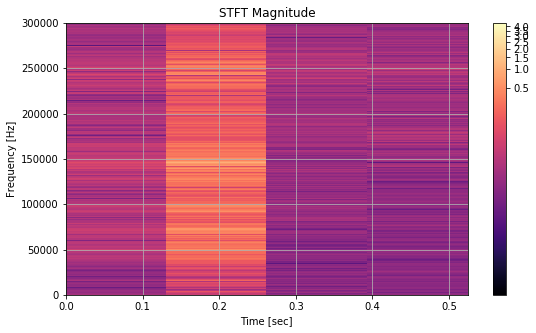

In [9]:
calcSTFT_norm(train['acoustic_data'], 4e6, nperseg=1048576, ylim_max=300000)

From the plot above, we can see there's a sharp signal (i.e. goes to a high frequency range) around 1.2 seconds of the signal.

## Time-frequency analysis in near-failure periods:

As stated in the previous version of this kernel, we cannot affirm there is any relation between the pulses in the frequency domain and the seismic activities: the event shown in time 0.2s (or 1.2s) could be due to a measurement error, for example.  

In order to obtain more solid evidences of this hypothetical relationship, I propose the following test: select the positions in the dataset where the *time_to_failure* attribute is close to null (i.e. where the failure is occurring is a local minimum) and check the domain frequency for a given interval before it.

### Finding the failure positions and regions
Since we are working with a huge dataset (at least when running the kernel on Kaggle's cloud), the most efficient way to process the data is reading it in chunks, from where we will look for the local minima, or the "failure time". Then, for each failure time in each chunk we will extract the **failure region**, defined as the 1.0s before the failure and the 0.25s after the failure. The region limits are calculated by the sampling frequency, which results that *1e6* samples are equivalent to 0.25s.

In [10]:
## Creating a list of positions where the "time_to_failure" is null
failure_regions = {}

In [11]:
## Defining a function to find the local minima positions
def is_failure(df):
    failures = df.index[(df.time_to_failure.shift(1) > df.time_to_failure) & (df.time_to_failure.shift(-1) > df.time_to_failure)].tolist()
    return failures

In [12]:
## Returns a signal region for a given failure position in a pandas.chunk:
## REMEMBER: a chunk is a pandas.Dataframe.
def region_readChunk(pos, chunk):
    ## Setting the region limits:
    beforePos = pos - 4e6
    afterPos = pos + 1e6
    #In some cases it can be shorter than the other regions
    if beforePos < chunk.index.min():
        beforePos = chunk.index.min()
    if afterPos > chunk.index.max():
        afterPos = chunk.index.max()
    ## Extracting the region data:
    data = chunk.loc[int(beforePos):int(afterPos)]
    return data

In [ ]:
## Processing the dataset in chunks:
## For each chunk, find the local minima and extract the respective region.
for chunk in pd.read_csv('../input/train.csv', chunksize=5e7, 
                         dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}):
    failure_pos = is_failure(chunk)
    for pos in failure_pos:
        data = region_readChunk(pos, chunk)
        failure_regions[pos] = data

In [ ]:
## Garbage collection (to reduce used memory)
gc.collect()

Once the data wrangling process is finished, we then obtain a dictionary (it could be stored in any other data structure) where the keys are the failure positions and the items correspond to the failure regions. 

In [ ]:
failure_regions.keys()

### Choosing the right chunk size
I initialy set the chunksize attribute as 5e6. However, this lead to many failure positions starting almost in the beginning of the chunk. To choose it more appropriately, I will now check if is there a regular space among them:

In [ ]:
posFailures = pd.DataFrame(list(failure_regions.keys()))
posFailures.describe()

We can notice that the failure positions are around 3e8 with a standard deviation about 2e8. From this we can choose 5e8 as an appropriate chunk size.

### Analyzing the failure regions

In [ ]:
def region_plot(df):
    data = df.copy()
    ##Aplying a 1e3 gain to the "time_to_failure" in order to make the failure visible
    data['time_to_failure'] = data['time_to_failure']*100
    ##Calculate elapsed time through the index and sampling frequency (4e6 MHz)
    data['time'] = data.index
    data['time'] = data['time']*(1/4e6)
    ##Normalize time information (0.0s  to 1.25s)
    data['Time [sec]'] = data['time'] - data['time'].min()
    ##Plot lines
    data[['acoustic_data','time_to_failure','Time [sec]']].plot(x='Time [sec]', figsize=(8,5))
    return

The code above could be use to analyze the signal region of each failure point. However, since it uses too much memory, we will choose a random one:

In [ ]:
#for key, value in failure_regions.items():
#    region_plot(value)

In [ ]:
region_plot(failure_regions[419368879])

In [ ]:
calcSTFT_norm(failure_regions[419368879]['acoustic_data'], 4e6, nperseg=1048576, ylim_max=300000)

## Discussion and the next steps

In the previous version of this kernel we could not affirm that a time-frequency analysis would be useful for this problem. However, since now we extend it to all the failure points, there are some evidences that time-frequency analysis can be useful for interpreting or even for feature extraction.